# BBC News Article Category Classification Using NLP and ML

## Introduction
This project aims to classify BBC news articles into predefined categories (tech, entertainment, sports, politics, business) using Natural Language Processing (NLP) techniques and both unsupervised and supervised machine learning models. By transforming article text into numerical features and analyzing structure via dimensionality reduction and classification models, we explore different approaches for categorizing unseen text data and evaluating their performance.

## Data Overview and Preprocessing
We use the BBC News Train/Test datasets, each containing article Text, ArticleId, and Category (only in training). After verifying no missing values, we tokenize and clean the text using TF-IDF vectorization with English stopwords removed. We also examine basic statistics like word counts and category distributions.

Exploratory Analysis Highlights:Distribution of article lengths (word counts), Count of articles by category, Average word count per category

Data downloaded from kaggle here: https://www.kaggle.com/competitions/learn-ai-bbc/data 

## Exploratory Data Analysis (EDA)
Converted all article text to lowercase (default in TfidfVectorizer)

Transformed articles into TF-IDF weighted matrices

Visualized distribution of word counts

Counted and visualized each category

Calculated and plotted average word count per category

These steps helped us understand the structure and volume of the textual data before modeling.

## Part 2: Unsupervised Learning with Truncated SVD
We applied Truncated SVD (Latent Semantic Analysis) to reduce the dimensionality of the TF-IDF matrix into topic-based representations. For several values of n_components (5, 10, 20, 50, 100), we:

Normalized topic vectors

Matched each article to its nearest neighbor (using cosine similarity)

Predicted labels from the most similar article

Recorded accuracy and visualized the impact of topic count

Best accuracy was achieved with 10 topics, yielding ~95.7% train accuracy. We saved predictions for the test set and visualized the resulting label distribution as a pie chart.

## Part 3: Supervised Learning with Logistic Regression
To benchmark the unsupervised results, we trained a Logistic Regression model on the full TF-IDF vectors and corresponding labels.

Achieved 99.8% training accuracy

Displayed the confusion matrix

Tested various training sizes (10%, 20%, 50%, 99%) showing consistently high performance even on small labeled subsets

This highlights the power of supervised learning when labels are available.

## Results and Discussion
Unsupervised SVD + cosine similarity achieved strong results (~95% accuracy), with performance plateauing around 10 topics.

Supervised Logistic Regression outperformed SVD, reaching nearly perfect accuracy, but risks overfitting when label coverage is limited.

Category prediction from SVD showed some category confusion, while supervised learning yielded more distinct boundaries.

Overall, unsupervised methods offer robust performance without labels, while supervised models excel when labeled data is sufficient. The choice depends on the availability of labeled data and the intended use case.

# EDA

Checking for null values, making sure all the text is lowercase, transformed into TF-IDF matrices, and looking at some word count & categorical statistics.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
test = pd.read_csv("statistics/BBCNewsTest.csv")
train = pd.read_csv("statistics/BBCNewsTrain.csv")

num_observations = train.shape[0]
num_features = train.shape[1]
data_info = train.info()
data_head = train.head()

data_info, data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB


(None,
    ArticleId                                               Text  Category
 0       1833  worldcom ex-boss launches defence lawyers defe...  business
 1        154  german business confidence slides german busin...  business
 2       1101  bbc poll indicates economic gloom citizens in ...  business
 3       1976  lifestyle  governs mobile choice  faster  bett...      tech
 4        917  enron bosses in $168m payout eighteen former e...  business)

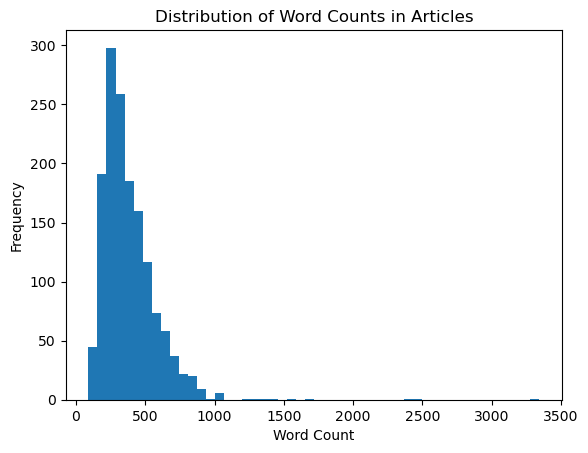

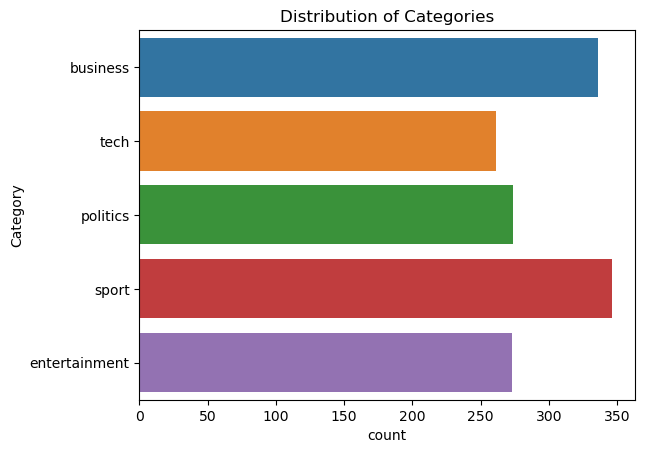

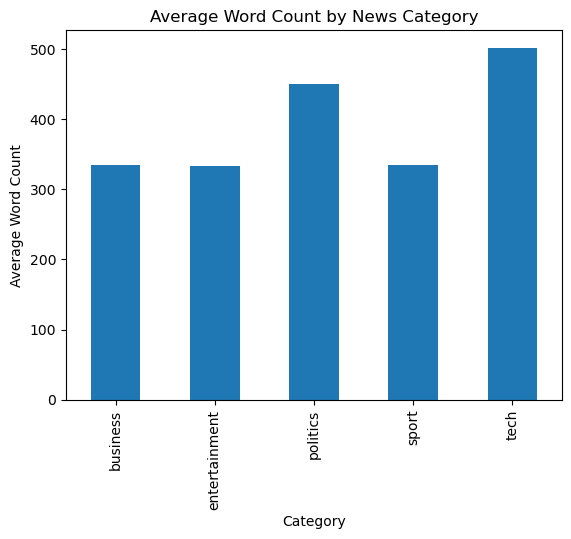

In [3]:
# 1. EDA and Cleaning

# cleaning words
vectorizer = TfidfVectorizer(stop_words='english')  # lowercase=True is default
X = vectorizer.fit_transform(train['Text'])
X_test = vectorizer.transform(test['Text'])

#getting wordcount graph
train['word_count'] = train['Text'].apply(lambda x: len(x.split()))
plt.hist(train['word_count'], bins=50)
plt.title("Distribution of Word Counts in Articles")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

#getting categorical counts
sns.countplot(y=train['Category'])
plt.title("Distribution of Categories")
plt.show()

# Group by category and compute average word count
avg_word_count = train.groupby('Category')['word_count'].mean()

#getting avg word count per category
avg_word_count.plot(kind='bar')
plt.title("Average Word Count by News Category")
plt.ylabel("Average Word Count")
plt.xlabel("Category")
plt.show()

# Part 2: Truncated SVD matrx factorization
We will be using TF-IDF vectorization to convert text into numerical word-weight features and remove english stopwords. We will then use Truncated SVD matrx factorization using n_components hyperparameter. We will test multiple values of n_components and use the most accurate number. We also will normalize both the training and test matrices for cosine similarity calculations.

For each number of topics the goal is to:

Predict the training set categories by finding the most similar article in the training set itself using cosine similarity, and evaluated accuracy. And predict test set categories using nearest-neighbor matching from test → train and saved predictions.


Then, collect training accuracy for each n_components setting and plotted it to observe the impact of topic count on accuracy, and identified the best-performing number of topics based on training accuracy and displayed a confusion matrix showing how the model confused categories.

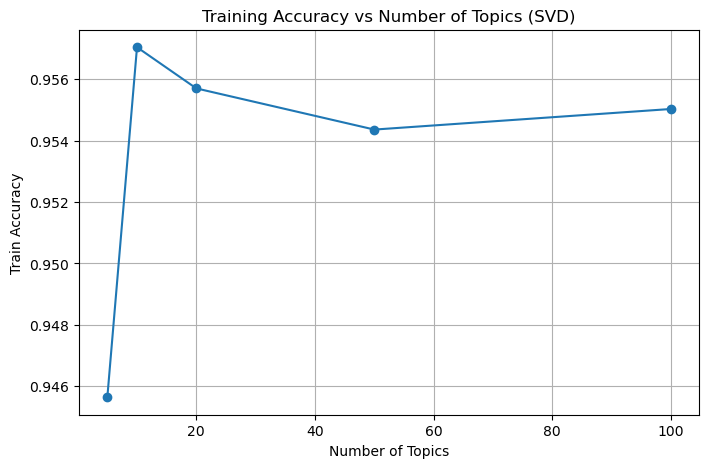

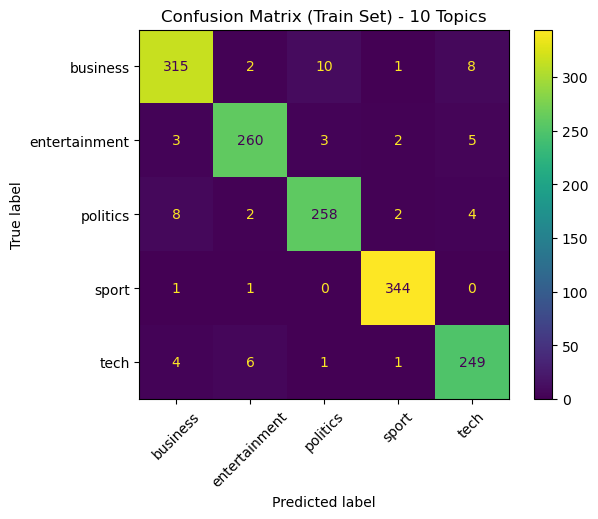

,n_topics,train_accuracy
0,5,0.945638
1,10,0.957047
2,20,0.955705
3,50,0.954362
4,100,0.955034


In [22]:
# Load data
train = pd.read_csv("statistics/BBCNewsTrain.csv")
test = pd.read_csv("statistics/BBCNewsTest.csv")

# Vectorize text data
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(train['Text'])
X_test = vectorizer.transform(test['Text'])

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(train['Category'])

# Try different numbers of topics for matrix factorization
n_topics_list = [5, 10, 20, 50, 100]
results = []

for n_topics in n_topics_list:
    svd = TruncatedSVD(n_components=n_topics, random_state=42)
    X_reduced = svd.fit_transform(X)
    X_test_reduced = svd.transform(X_test)

    # Normalize
    X_reduced_norm = normalize(X_reduced)
    X_test_reduced_norm = normalize(X_test_reduced)

    # Predict train to train for accuracy
    similarity_matrix_train = cosine_similarity(X_reduced_norm, X_reduced_norm)
    np.fill_diagonal(similarity_matrix_train, -1)
    train_nn = similarity_matrix_train.argmax(axis=1)
    y_train_pred = y_train[train_nn]
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Predict test labels
    similarity_matrix_test = cosine_similarity(X_test_reduced_norm, X_reduced_norm)
    test_nn = similarity_matrix_test.argmax(axis=1)
    y_test_pred = y_train[test_nn]
    test['PredictedCategory'] = le.inverse_transform(y_test_pred)

    results.append({
        'n_topics': n_topics,
        'train_accuracy': train_accuracy
    })

# Plotting accuracy vs. number of topics
results_df = pd.DataFrame(results)
plt.figure(figsize=(8, 5))
plt.plot(results_df['n_topics'], results_df['train_accuracy'], marker='o')
plt.title("Training Accuracy vs Number of Topics (SVD)")
plt.xlabel("Number of Topics")
plt.ylabel("Train Accuracy")
plt.grid(True)
plt.show()

# Confusion matrix on train set for best model (highest accuracy)
best_n_topics = results_df.loc[results_df['train_accuracy'].idxmax(), 'n_topics']
best_preds = results_df['train_accuracy'].idxmax()

svd = TruncatedSVD(n_components=int(best_n_topics), random_state=42)
X_reduced = svd.fit_transform(X)
X_reduced_norm = normalize(X_reduced)
similarity_matrix_train = cosine_similarity(X_reduced_norm, X_reduced_norm)
np.fill_diagonal(similarity_matrix_train, -1)
train_nn = similarity_matrix_train.argmax(axis=1)
y_train_pred = y_train[train_nn]

# Display confusion matrix
cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45)
plt.title(f"Confusion Matrix (Train Set) - {int(best_n_topics)} Topics")
plt.show()

results_df


10_topics gave us the best accuracy on training data., below we will save the predicted categories for 10_topics and show the distribution of predictions in a pie chart of Predicted Category.

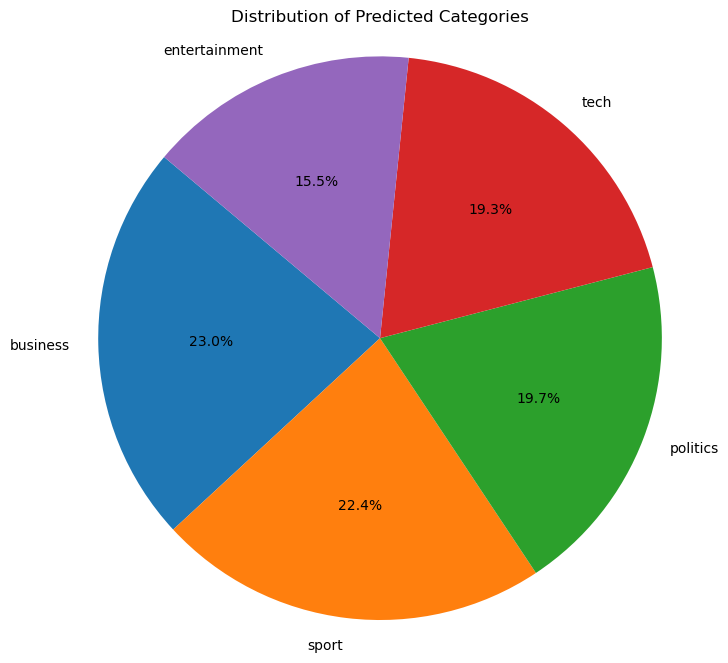

In [24]:
# Save for submission
submission = test[['ArticleId', 'PredictedCategory']]
submission.to_csv('unsupervised_svd_submission.csv', index=False)

category_counts = test['PredictedCategory'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Predicted Categories")
plt.axis('equal')  # Ensures pie is a circle
plt.show()


# Part 3: Supervised approach: Logistic Regression
We will now compare supervised approach with our unsupervised approach.

Train Accuracy: 0.9979865771812081


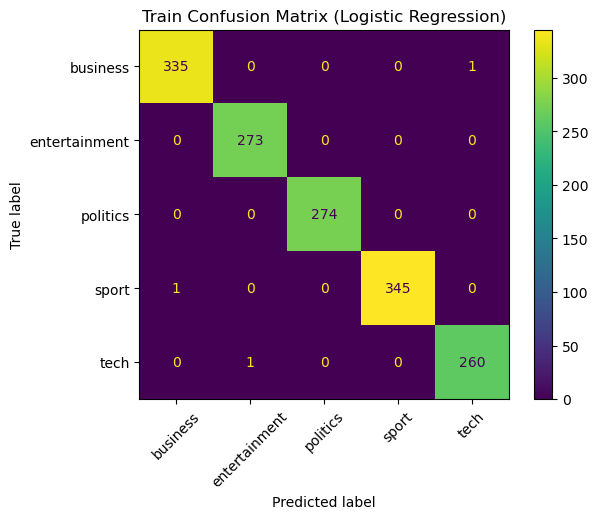

In [11]:
# Use full data that have already been transformed into TF-IDF matrices
X_train_full, y_train_full = X, y_train

# Train a Logistic Regression model
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_full, y_train_full)

# Predict on train and test
y_train_pred = clf.predict(X_train_full)
y_test_pred = clf.predict(X_test)

# Accuracy
print("Train Accuracy:", accuracy_score(y_train_full, y_train_pred))
# Note: test accuracy requires test labels, which you don't have unless using Kaggle

# Confusion Matrix (Train)
cm = confusion_matrix(y_train_full, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45)
plt.title("Train Confusion Matrix (Logistic Regression)")
plt.show()

We will try changing the train data size (e.g., Include only 10%, 20%, 50% of labels, and observe train/test performance changes).

In [18]:
# Try 10%, 20%, 50% of data
for frac in [0.1, 0.2, 0.5, .99]:
    X_train_frac, _, y_train_frac, _ = train_test_split(X, y_train, train_size=frac, stratify=y_train, random_state=42)
    
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_train_frac, y_train_frac)
    
    y_pred_frac = clf.predict(X_train_frac)
    acc = accuracy_score(y_train_frac, y_pred_frac)
    print(f"Train accuracy using {int(frac*100)}% of data: {acc:.4f}")

Train accuracy using 10% of data: 1.0000
Train accuracy using 20% of data: 1.0000
Train accuracy using 50% of data: 0.9987
Train accuracy using 99% of data: 0.9980


# Results comparison: supervised vs unsupervised
The supervised model performed better overall, it is possible that overfitting is more of an issue in the supervised approach. unsupervised matrix factorization doesn't benefit directly from labeled data and may require more tuning or richer feature engineering to match supervised performance. So supervised models generally outperform in accuracy when labels are available, especially with enough data.

Supervised models would likely be preferred in situations where labels are explicitly defined.
